### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성청년SW·AI아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

### **Objectives**

1. **실습명**: MLP 구현

2. **핵심 주제**
  - PyTorch nn.Sequential을 이용한 MLP 아키텍처 설계
  - forward와 \_\_call\_\_ 매직 메서드의 역할 이해
  - 학습/검증 루프 구성 및 Early Stopping을 활용한 모델 평가

3. **학습 목표**
  - MLP 모델 구조를 설계하고 구현할 수 있다.
  - PyTorch의 `forward` 호출 메커니즘을 설명할 수 있다.
  - `DataLoader`와 `Dataset`을 활용해 데이터 배치 처리 코드를 작성할 수 있다.
  - 학습 중 `train()`/`eval()` 모드 전환과 Dropout 동작을 검증할 수 있다.
  - 검증 손실 기준으로 Early Stopping을 적용해 최적의 모델을 저장·불러올 수 있다.

4. **학습 개념**
  - **`nn.Module`**: PyTorch 모델 클래스의 기본 인터페이스로, `forward`와 매직 메서드를 지원한다.
  - **`__call__`**: 객체에 () 연산을 걸면 내부에서 `forward` 호출 흐름을 관리하는 매직 메서드다.
  - **`DataLoader`**: `Dataset`을 배치 단위로 읽어오고, shuffle·병렬 로딩을 지원하는 헬퍼 클래스다.

5. **학습 방향**
  - 실습은 PyTorch 기반의 MLP 모델을 순차적으로 설계·구현합니다.
  - 먼저 `nn.Sequential`을 사용해 3계층 MLP를 정의한 뒤, `forward`와 `__call__` 매커니즘을 검토합니다.
  - `sklearn.datasets.load_digits`로 손글씨 숫자 데이터를 로드하고, `train_test_split`으로 80/10/10 분할 후 `StandardScaler`로 정규화합니다.
  - 변환된 NumPy 배열을 `TensorDataset`과 `DataLoader`로 감싸 배치 처리를 구현하고, 학습/검증 루프를 작성합니다.
  - `train()`/`eval()` 모드를 전환하며 Dropout 동작을 확인하고, 검증 손실 기반 Early Stopping으로 최적 체크포인트를 저장합니다.

6. **데이터셋 개요 및 저작권 정보**
  - 데이터셋 명: sklearn `load_digits`
  - 데이터셋 개요: 8×8 화소로 축소된 손글씨 숫자 이미지 1,797개와 레이블(0–9)로 구성된 분류용 데이터셋
  - 데이터셋 저작권: 원본은 UCI Machine Learning Repository 공개 도메인 데이터이며, scikit-learn에서 재배포 및 가공하여 제공됩니다.


### **Prerequisites**
```
numpy>=1.26
pandas>=2.0
scikit-learn>=1.4
seaborn>=0.12
torch>=2.2
matplotlib>=3.8
```


# 🔥 PyTorch를 활용한 MLP 구현하기
**학습 목표**
  - PyTorch nn.Module에서 `forward`가 어떻게 연동되어 함수 호출처럼 동작하는지 이해한다.
  - 모델 객체를 호출할 때 실행되는 전처리(pre-forward hook), 순전파(forward), 후처리(post-forward hook), 자동미분 그래프 등록 과정을 단계별로 파악할 수 있다.

**학습 개념**
  - `forward` : 사용자가 구현하는 순전파 로직 메서드로, `__call__`에 의해 자동 실행됨
  - Hook : 모듈 실행 전(pre-forward)·후(post-forward) 시점에 추가 로직을 삽입할 때 사용하는 함수
  - Autograd : 연산 그래프를 동적으로 구성하고 역전파(backpropagation)를 수행하는 PyTorch 자동 미분 엔진
  - nn.Module : 파라미터 관리, hook 등록 기능을 제공하는 PyTorch 모델의 기본 클래스

**진행하는 실습 요약**
  - 간단한 `nn.Module` 서브클래스를 정의하고 `forward` 메서드를 구현한다.
  - 자동미분을 위한 그래프 노드 등록 순서로 동작하는 것을 코드로 직접 확인한다.
  - 손수 hook 함수를 등록해 실행 순서를 출력해 보고, 실제 `criterion(y_pred, y_true)`도 동일한 `forward` 흐름을 사용함을 실습한다.
  - 이 과정을 통해 PyTorch 모듈이 함수처럼 호출되는 메커니즘을 명확히 이해하고, 커스텀 레이어 설계 를 학습한다.

오늘은 드디어 가장 기초적인 딥러닝 실습을 진행할 예정입니다. PyTorch 라이브러리를 통해 기본적인 Multi-layer Perceptron을 구현하여 학습하는 방법에 대해서 배워볼 예정입니다! 이번 실습은모델을 성공적으로 학습시키는 것보다, PyTorch와 친해지는 것에 초점을 둡니다.

**런타임 변경**
- 본 실습을 시작하기 전에 설정할 것이 있습니다. 바로 해당 Colaboratory 세션의 런타임을 변경하는 것입니다. 딥러닝은 행렬곱을 많이 사용하기 때문에 단순한 병렬계산이 많이 사용됩니다. 여기에 유리한 것이 바로 GPU입니다. 우측 상단의 ▾ 모양의 드롭다운을 눌러 Change Runtime Type ➡️ T4 GPU 선택 ➡️ Disconnect and delet runtime 팝업이 뜨면 OK 선택 ➡️ Save 를 통해 Runtime을 변경해줍니다.

- 이를 먼저 수행하는 이유는 런타임이 변경되면 현재 작업 중인 변수들이 초기화되기 때문입니다. 그래서 시작 전에 변경해주어야 합니다.

- ⚠️ GPU는 비싼 리소스입니다. 한정된 자원을 여러 사용자가 나눠 사용하기 때문에, GPU를 할당 받은 후 활동이 없거나, 일정시간 이상 사용하게 되면 자동으로 리소스가 반환되는 점 유의해주세요. 따라서 당장 학습을 진행하는 것이 아니라 이런 저런 테스트를 진행해보는 중이라면 굳이 런타임을 GPU로 변경하지 않는 것을 추천합니다!
- 참고: [Colab FAQ](https://research.google.com/colaboratory/faq.html)


**🔥 PyTorch**     
본격적으로 PyTorch를 사용해봅시다. Colab에는 기본적으로 torch가 설치되어 있기 때문에 Colab 환경 사용시 별도의 설치가 필요하지 않습니다. 하지만 만약 추가로 설치해야한다면 홈페이지에 방문하여 본인의 환경에 맞춰 설치를 진행해주세요.
- https://pytorch.org/get-started/locally/


PyTorch는 NumPy와 사용이 유사합니다. 실제로 사용자들의 혼란을 줄이기 위해 NumPy에 존재하는 같은 기능의 함수를 같은 이름으로 구현해둔 것이 대부분입니다. 하지만 일부 차이가 존재할 수 있기 때문에 정확한 동작을 이해하기 위해서는 API Reference를 항상 참고해주세요.

NumPy의 시작이 np.array였다면 PyTorch의 시작은 torch.Tensor입니다. 모든 것은 텐서를 기반으로 동작합니다.

In [ ]:
import torch

x = torch.rand(3, 3)   # 0~1 사이 랜덤 값
y = torch.ones(3, 3)   # 모두 1인 텐서
print("x:\n", x)
print("y:\n", y)
print("x + y:\n", x + y)
print("x @ y.T:\n", x @ y.T)  # 행렬곱

x:
 tensor([[0.5059, 0.1961, 0.7272],
        [0.6410, 0.9498, 0.2621],
        [0.7317, 0.1435, 0.6068]])
y:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
x + y:
 tensor([[1.5059, 1.1961, 1.7272],
        [1.6410, 1.9498, 1.2621],
        [1.7317, 1.1435, 1.6068]])
x @ y.T:
 tensor([[1.4292, 1.4292, 1.4292],
        [1.8529, 1.8529, 1.8529],
        [1.4820, 1.4820, 1.4820]])


가속화가 필수라면... 굳이 PyTorch를 쓰지 않고 NumPy를 CUDA에서 사용할 수 있게 만든 CuPy를 쓰는게 낫지 않았을까요? PyTorch를 사용해야하는 가장 큰 이유는 바로 AutoGrad 기능 때문입니다.

**Pytorch Autograd**   
Autograd는 PyTorch에서 자동으로 미분을 계산해주는 엔진입니다.
우리가 텐서 연산을 수행하면, PyTorch는 연산 그래프(computational graph) 를 만들고,
.backward() 호출 시 그 그래프를 따라 역전파(Backpropagation) 를 실행하여 기울기를 구합니다.

1. 기본 동작 원리
  -	`requires_grad=True` 로 설정된 텐서에 대해 모든 연산 과정을 추적합니다.
  -	연산이 일어날 때마다 `grad_fn` 이라는 연산 노드가 연결되어 그래프가 확장됩니다.
  -	`.backward()`를 호출하면, 스칼라 값에서 시작하여 그래프를 따라 거꾸로 기울기를 전파합니다.
  -	계산된 기울기는 `.grad` 속성에 저장됩니다.

2. 예시:
$$ y = x^2 + 3x + 1, x, y \in R^2 $$
$$ z = y_1 + y_2 $$

여기서 어떤 하나의 스칼라 출력값 $z$는 $x$의 변화에 어떻게 반응할까요? 우리는 이를 $\frac{\partial z}{\partial x}$라고 표기되는 미분이라 표현하고 우리는 역전파를 위해 이 값이 늘 필요합니다. 수식을 조금 더 구체적으로 살펴볼까요? $z$라는 변수는 $x$라는 벡터에 의해서 변하기 때문에 다음과 같이 표기합니다.
$$
\frac{\partial z}{\partial x}=[ \frac{\partial z}{\partial x_1} , \frac{\partial z}{\partial x_2} ]
$$

$$
= [ \frac{\partial z}{\partial y_1} \frac{\partial y_1}{\partial x_1} ,  \frac{\partial z}{\partial y_2} \frac{\partial y_2}{\partial x_2} ]
$$

$\frac{\partial z}{\partial y}$는 모두 1이기 대문에 실질적으로 $\frac{\partial y}{\partial x}$만 계산해주면 됩니다. $x$에 대한 $y$의 미분은 손쉽게 $2x+3$이 되는 것을 알기 때문에 최종적으로 미분은 다음과 같이 계산됩니다.

$$
\frac{\partial z}{\partial x}=[2x_1+3, 2x_2+3]
$$

실제로 이렇게 계산되는지 확인해볼까요? 아래 코드를 살펴봅시다. 현재 $x=[2, 3]$인 벡터를 가정하고 연산을 해봅시다. 수식에 따르면 $\frac{\partial z}{\partial x}=[7, 9]$가 계산되어야 합니다.

In [ ]:
x = torch.tensor([2.0, 3.0], requires_grad=True)
y = x ** 2 + 3 * x + 1
z = y.sum()        # 스칼라

z.backward()       # 역전파 시작
print(x.grad)      # dz/dx 값 출력: [7., 9.]

tensor([7., 9.])


실제로 잘 계산되었나요? 이를 어떻게 응용해볼 수 있을까요? 선형회귀 모델을 다시 떠올려봅시다. 아주 간단한 모델을 생각해보겠습니다.

$$ y = \theta x + b $$

여기서 $\theta$와 $b$는 학습해야하는 매개변수이고, 실제로 예측해야하는 회귀 타겟변수 $y$, 그리고 독립변수 $x$가 존재한다고 해봅시다. 어떻게 경사하강법을 진행했었는지 다시 떠올려봅시다.

데이터가 `x=2`, `y=4`인 상황이라고 가정합시다.
1. 초기 매개변수값 설정 (e.g. $\theta=3$, $b=1$)
2. 현재 매개변수를 통한 예측값 출력 (e.g. $\hat{y}=3\times2+1=7$)
3. MSE 계산 (e.g. $L=(\hat{y}-y)^2=(7-4)^2=3$)
4. MSE를 기반으로 미분 후 업데이트
  - $\frac{\partial L}{\partial \theta}=\frac{1}{n}\sum{2(\hat{y}-y})x=2\times3\times2=12$
  - $\frac{\partial L}{\partial \theta}=\frac{1}{n}\sum{2(\hat{y}-y})=2\times3=6$

복습해보니 기억이 나시나요? 아래 수식으로 실제로 계산이 되는지 확인해봅시다.

In [ ]:
# 파라미터 정의 (requires_grad=True)
weight = torch.tensor([[3.0]], requires_grad=True)
bias   = torch.tensor([[1.0]], requires_grad=True)

# 입력과 목표값
x = torch.tensor([[2.0]])
y_true = torch.tensor([[4.0]])

# 순전파 → 손실 계산
y_pred = x @ weight + bias              # 선형 모델
loss = torch.mean((y_pred - y_true) ** 2)

# 역전파
loss.backward()

weight.grad, bias.grad

(tensor([[12.]]), tensor([[6.]]))

오 실제로 미분값이 잘 나오네요. 여기서 우리가 업데이트를 진행해주는 방식은 현재 매개변수에서 학습률만큼 곱한 미분을 빼주는 것이었습니다. 코드를 마저 마무리해보면

In [ ]:
# 파라미터 업데이트
with torch.no_grad():
    # requires_grad=True인 텐서는 inplace operation (+=, -=와 같은)이 불가합니다.
    # 이런 경우 torch.no_grad context를 켜서 작업해주면
    weight -= 0.1 * weight.grad
    bias   -= 0.1 * bias.grad

    # 미분은 덮어쓰는게 아니라 누적 되기 때문에 없애줘야함.
    # weight / bias의 미분을 중간중간 없애줘야함
    weight.grad.zero_()
    bias.grad.zero_()

print(weight, bias)

tensor([[1.8000]], requires_grad=True) tensor([[0.4000]], requires_grad=True)


잘 업데이트된걸 확인할 수 있습니다 :)   
하지만 아직은 PyTorch의 장점을 모두 사용하지는 않았습니다. 아무래도 학습에서 제일 중요한 부분은 미분을 계산하는 부분이지만, 그 밖에 많은 부분들은 여전히 수동적으로 업데이트합니다. 위의 코드에서 몇 가지를 자동화해볼 수 있습니다.

1. **Parameter 선언**: 선형모델에서 Feature마다 곱해지는 선형계수를 간단하게 처리할 수 있습니다. 편향항까지 따로 정의하지않고 계산할 수 있습니다.
2. **손실함수 정의**: MSE와 같이 단순한 수식은 함수로 정의하면 좋지만, 새로운 프로젝트가 생기면 거기에 또다시 MSE를 작성해야 합니다. 이는 코드 관리를 하는데 있어 불리한 면이 작용합니다. PyTorch에는 우리가 자주 쓰는 MSELoss 같은 손실함수들이 구현되어 있습니다. import 후 사용하면 됩니다 :)
2. **Parameter 업데이트**: torch.optim 모듈은 우리가 학습해야하는 파라미터를 등록하면, 미분값에 따라 자동으로 업데이트해주는 기능을 가지고 있습니다.

설명만 듣고는 이해가 어렵습니다. 다음 코드를 확인해봅시다.

In [ ]:
from torch import nn
from torch import optim

# 더미 데이터 준비: y = 2x + 1
X = torch.linspace(0, 10, 100).unsqueeze(1)  # shape: (100, 1)
y_true = 2 * X + 1 + 0.5 * torch.randn_like(X)  # 약간의 노이즈 추가

# 1. Paramter 선언
# 이렇게 하면 weight, bias가 자동으로 준비됩니다.
# 우리는 1차원 변수 x로 1차원 변수 y를 예측하기 때문에 아래와 같이 선언하면 됩니다.
model = nn.Linear(in_features=1, out_features=1)  # 입력 1차원, 출력 1차원

# 2. 손실 함수 정의
# torch.nn에서 불러올 수 있습니다.
criterion = nn.MSELoss()

# 3. Parameter 업데이트
# 현재 사용하고 있는 업데이트 방식은 Mini-batch Gradient Descent입니다.
# 정확한 정의는 batch_size=1일때 Stochastic Gradient Descent, 줄여서 SGD라고 부르는데
# PyTorch에서는 가장 기본적인 미분 기반의 업데이트 방식을 SGD를 선언하여 진행할 수 있습니다.
# 선언할 떄는 업데이트 대상인 매개변수와 학습률을 입력해야합니다.
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 4. 학습 루프
epochs = 200
for epoch in range(epochs):
    # 기울기 초기화: 위에서 진행한 weight.grad.zero_()를 자동으로 수행해줍니다.
    # 수행대상은 선언할 때 등록한 모델의 매개변수입니다.
    optimizer.zero_grad()

    # 예측값 만들어주기: model(X)로 가능합니다
    # 이에 대한 자세한 작동방식은 후에 살펴보겠습니다.
    y_pred = model(X)

    # Loss 계산도 마찬가지로 위에서 선언한 손실함수를 활용합니다.
    loss = criterion(y_pred, y_true)

    # Loss를 계산하고 미분을 계산해줍니다.
    loss.backward()

    # 매개변수를 업데이트해줍니다.
    # 위에서 진행한 weight -= lr * weight.grad 부분입니다.
    # 모든 매개변수가 optimizer 안에 등록되어 있기 때문에
    # 매개변수 별로 업데이트 코드를 짜주지 않아도 됩니다.
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 학습 결과 출력
print("\n학습된 가중치와 편향:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

Epoch [20/200], Loss: 0.2310
Epoch [40/200], Loss: 0.2307
Epoch [60/200], Loss: 0.2305
Epoch [80/200], Loss: 0.2303
Epoch [100/200], Loss: 0.2301
Epoch [120/200], Loss: 0.2300
Epoch [140/200], Loss: 0.2299
Epoch [160/200], Loss: 0.2298
Epoch [180/200], Loss: 0.2297
Epoch [200/200], Loss: 0.2297

학습된 가중치와 편향:
weight: tensor([[2.0010]])
bias: tensor([0.9972])



가장 기본적인 PyTorch 학습코드를 완성시켰습니다 🎉. 그 외에 대다수 연산은 `numpy`와 유사한 점이 많기 때문에 크게 어려운 점이 없을겁니다. 추가로 알아야할 사항이 있습니다.

1. 가속화 기기 활용하기: torch.Tensor를 CPU가 아닌 GPU 연산을 사용하려면 `.to` 메소드를 활용해야 합니다. 다음 셀에서 예제로 살펴보겠습니다.
2. `numpy.array` ↔️ `torch.Tensor`: 두 라이브러리 사이 데이터를 변환하는 것은 자주 등장하기 때문에 알아두어야합니다.
3. 복잡한 모델 구성하기: 위에서는 `nn.Linear` 하나로 모델이 완성되었지만, 실제로 수업시간에 배운 Multi-Layer Perceptron 같은 비선형 모델을 구현하기 위해서는 추가적인 모듈이 필요합니다. 이를 하나의 모듈로 결합하는 방법에 대해 배워봅시다.

In [ ]:
# 1. 가속화기기 활용하기
cuda_on = torch.cuda.is_available()
print(f"CUDA가 사용이 가능한가요?: {cuda_on}")

cpu_tensor = torch.eye(4)
# 여기서 에러가 동작한다면 런타임을 확인해주세요.
gpu_tensor = cpu_tensor.to("cuda")

print(f"CPU Tensor: {cpu_tensor}")
print(f"GPU Tensor: {gpu_tensor}")

CUDA가 사용이 가능한가요?: True
CPU Tensor: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
GPU Tensor: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')


In [ ]:
# 2. NumPy and Torch
import numpy as np

# numpy to torch
np_array = np.eye(4)
t_from_numpy = torch.from_numpy(np_array)
print(np_array, t_from_numpy)

# torch to numpy
# .numpy를 호출하면 쉽게 변환 가능합니다.
# 하지만 텐서가 CUDA에 올라가 있다면 CPU로 변환하고 작동시켜줘야합니다.
t_tensor = torch.eye(4).to("cuda")
np_from_tensor = t_tensor.cpu().numpy()
print(t_tensor, np_from_tensor)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0') [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
# 3. Multi-Layer Perceptron 구성하기
# `nn.Linear`로도 해결이 가능하면 좋겠지만, 일반적으로 인공신경망은 이러한 선형레이어와
# 몇 가지 비선형 함수를 추가하여 구성됩니다.
# 복잡한 구성들을 하나의 모델로 합쳐서 사용하는 방법을 배워봅시다.

import torch
import torch.nn as nn


class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # 모델의 구성요소를 정의하는 부분입니다.

        # 🌟 PyTorch 모델을 구성할 때 항상 넣어줘야하는 코드입니다.
        super().__init__()

        # 여기에 Layer를 정의합니다.
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 실제 데이터를 입력으로 받았을 때 __init__에서 정의한 레이어 순서대로 입력을 보내주는 코드입니다.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class SequentialMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        # 위에서 제작한 코드가 기본적인 형태입니다.
        # 하지만 매번 forward에서 정의한 layer들을 쓰면서 넘기기는 귀찮네요.
        # nn.Sequential을 이용하면 귀찮음을 해결할 수 있습니다.
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # 귀찮음 해결 ☝️
        return self.layers(x)


# 실제로 작동하는 모델을 선언하려면 위에서 정의한 클래스를 객체로 만들어줘야합니다.
model = SequentialMLP(input_dim=20, hidden_dim=10, output_dim=1)

# 더미데이터를 만들어서 의도한대로 작동하는지 확인하는 작업입니다.
# 위에서 모델을 정의할 때 input_dim=20으로 만들었기 때문에 특성이 20개인 데이터를 만들어줍니다.
# 예시로 전체 데이터의 수는 40건이 있다고 가정합시다.
# 그렇다면 X는 다음과 같이 정의됩니다.
X = torch.ones(size=(40, 20))
y_pred = model(X)
y_pred.size()

torch.Size([40, 1])

지금 위에서 더미데이터를 생성할 때 텐서의 모양이 (40, 20)이었습니다. `nn.Linear`의 입력은 항상 (데이터의수, 입력차원수)로 받아줘야합니다. 왜냐하면 PyTorch는 데이터 학습을 배치처리하는데 효율적인 방법을 구현했기 때문입니다 :) 그래서 출력값 또한 (데이터수, 1)이 됩니다. `SequentialMLP`의 마지막 레이어가 `nn.Linear(hidden_dim, 1)`이기 떄문에 출력 특성수가 하나이기 때문입니다.

### 📝 참고: 객체에 `()`를 걸면 어떻게 될까?

위에서 조금 독특한 연산이 있습니다. 바로 `model(X)`와 `criterion(y_pred, y_true)`입니다. 단순 객체인데 왜 함수처럼 작동이 가능할까요? 정답은 예전에 설명한 magic method에 있습니다. 클래스에 `__call__`이 구현되어 있으면 생성한 객체를 함수처럼 사용할 수 있습니다.   

그렇다면 PyTorch 모듈도 `__call__`를 커스텀하면 될까요? 위에 코드를 보셔서 아시겠지만 우리는 `forward`를 구현하였습니다. 실제로 `model(X)`를 수행하면 `forward`가 호출하는데, 이것은 PyTorch 구현에서 필요한 모든 동작이 `__call__`에 이미 정의되어 있기 때문입니다.

`nn.Module`의 `__call__` 내부는 대략 다음 순서로 동작합니다:
  1. 입력 텐서에 대한 전처리(등록된 pre-forward hook 실행)
  2. 실제 forward 메서드 호출
  3. 출력 텐서에 대한 후처리(등록된 post-forward hook 실행)
  4. 자동미분을 위한 그래프 연결 및 backward hook 등록

따라서 사용자는 오직 `forward`만 구현하면 되고, 모델을 호출할 때마다 PyTorch가 알아서 `__call__` ↔ `forward` 흐름을 관리해 줍니다. 결론적으로, 커스텀 레이어를 만들 때는 `__call__`이 아니라 `forward`만 정의하면 충분합니다.


### 🧑‍💻 **실습**: 숫자 판독기 만들기

이번에는 숫자 판독기를 만들어봅시다. `sklearn.datasets.load_digits`는 사람 손으로 쓰여진 0-9까지의 흑백필기 사진이 담겨져있습니다. 이미지이지만 (8, 8) 사이즈 밖에 되지 않아서 이를 일렬로 펴서 Multi-Layer Perceptron에 통과시켜 숫자를 예측해봅시다.

아래 코드는 데이터에 대한 샘플입니다.


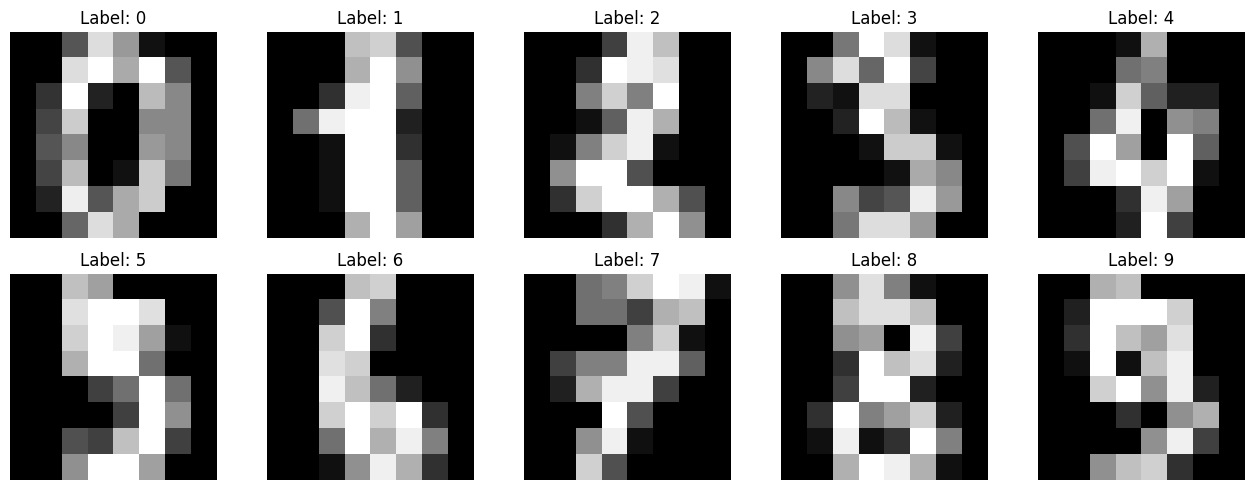

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data.astype(np.float32)  # (n_samples, 64)
y = digits.target.astype(np.int64)

# 데이터를 한 번 살펴봅시다.
fig, ax = plt.subplots(figsize=(13, 5), nrows=2, ncols=5)
for i in range(10):
    ax[i // 5, i % 5].imshow(X[i].reshape(8, 8), cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {y[i]}")
    ax[i // 5, i % 5].axis("off")
fig.tight_layout()

In [ ]:
# 아래는 난수를 고정하는 함수입니다.
# 재현성을 위해 구현되어 있습니다.
import random
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(seed=42)

In [ ]:
# 정답코드
# 1. 데이터를 분할하고 표준화해줍니다.
# 이번에는 검증데이터 (X_val)과 테스트데이터 (X_test)까지 만들어줍시다.
# X_test는 실제로 정답이 없는 처음 보는 데이터로 최종 성능을 확인해야할 데이터,
# X_val은 중간중간 모델의 검증결과를 확인하기 위한 데이터입니다.
# 학습데이터는 전체의 80%, 나머지 검증과 테스트데이터는 각각 10%씩 할당해주세요.
# 난수는 위에서 정의된 `SEED`를 활용해주세요.
# stratify 하는것도 잊지 마시구요.
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [ ]:
# 정답코드
# 2. PyTorch Dataset을 만들어줍니다
# batch 처리방식을 기억하시나요?
# 매번 X에서 인덱싱을 통해 데이터를 배치로 뽑아냈습니다.
# 여간 귀찮은게 아니었는데요, 이를 간편하게 만들어주는 방식이 PyTorch에 존재합니다.

# TODO:
# 모든 데이터를 텐서로 변환해주세요
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid)
y_valid_t = torch.from_numpy(y_valid)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

# TODO:
# Pytorch TensorDataset에 넣어줍시다.
# https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
from torch.utils.data import TensorDataset
train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

# TODO:
# 위에서 만든 TensorDataset을 DataLoader로 변환시켜줍니다.
# 둘의 차이를 간단하게 설명하자면
#   - Dataset: 데이터 하나를 어떻게 읽어올지 정의
#   - DataLoader: 배치처리를 어떻게할지 정의
# 따라서 DataLoader는 batch_size를 정의해줘야합니다.
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# 위에서 만든 Dataset과 DataLoader의 차이를 살펴봅시다.
# Dataset: 한 개를 정의한 것이기 때문에 단일 인덱싱이 가능합니다.
# Return 값은 TensorDataset에서 넣어준 데이터의 순서입니다.
# 즉 다음 코드는 (X_train_t[0], y_train_t[0])을 불러온 것이 됩니다.
train_ds[0]

(tensor([ 0.0000, -0.3305,  1.2379, -0.4274,  0.0231,  1.4301,  2.8413, -0.1258,
         -0.0610, -0.6226,  1.0317,  1.0094,  1.1938,  1.2650,  1.3998, -0.1343,
         -0.0373, -0.4417,  1.0597,  1.5556,  1.4434,  0.6599, -0.5538, -0.1186,
         -0.0264, -0.4668, -0.6766, -1.1465,  0.1848,  1.2609, -0.6283, -0.0528,
          0.0000, -0.6675, -1.0558, -1.4520, -1.4168,  1.2493, -0.8177,  0.0000,
         -0.0660,  0.4702,  0.7857, -1.1315, -0.7497,  1.2015, -0.8098, -0.0822,
         -0.0368,  2.9620,  1.3273, -0.3076,  0.6769,  0.3702, -0.7626, -0.2008,
         -0.0264, -0.2954,  0.6870,  0.4241, -0.5724, -0.8197, -0.5045, -0.1936]),
 tensor(5))

In [ ]:
# 또한 TensorDataset에 몇 개의 데이터가 들어있는지도 알 수 있습니다
len(train_ds)

1437

In [ ]:
# 반면 DataLoader는 단일데이터 처리용이 아니기 때문에 인덱싱이 불가능합니다.
# 따라서 다음 코드는 에러가 나타납니다.
train_loader[0]

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
# 그러면 단일 배치가 잘 불러졌는지 확인하는 방법에는 뭐가 있을까요?
# 힌트는 위에서 난 에러메시지에 있습니다. DataLoader를 Iterable 객체로 변환시켜주면 됩니다.
next(iter(train_loader))

[tensor([[ 0.0000, -0.3305,  0.3895,  ..., -1.1588, -0.5045, -0.1936],
         [ 0.0000, -0.3305, -1.0952,  ...,  0.5366, -0.0152, -0.1936],
         [ 0.0000, -0.3305, -1.0952,  ..., -0.9893, -0.5045, -0.1936],
         ...,
         [ 0.0000, -0.3305, -0.6710,  ...,  1.3843, -0.2599, -0.1936],
         [ 0.0000, -0.3305, -1.0952,  ..., -1.1588, -0.5045, -0.1936],
         [ 0.0000, -0.3305, -0.8831,  ...,  0.3670, -0.5045, -0.1936]]),
 tensor([7, 6, 7, 8, 4, 6, 3, 1, 2, 1, 4, 2, 6, 0, 1, 0, 8, 6, 1, 8, 4, 4, 3, 5,
         5, 5, 3, 7, 8, 6, 4, 6])]

In [ ]:
# 실제로 학습에서 활용할 때는 for loop에 넣어서 꺼내줍니다.
for idx, batch in enumerate(train_loader):
    print(idx, batch)
    break

0 [tensor([[ 0.0000, -0.3305, -0.4589,  ...,  0.8757,  0.9636, -0.1936],
        [ 0.0000, -0.3305, -0.6710,  ..., -0.4807, -0.5045, -0.1936],
        [ 0.0000, -0.3305,  1.0258,  ..., -1.1588, -0.5045, -0.1936],
        ...,
        [ 0.0000, -0.3305, -1.0952,  ..., -1.1588, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -0.6710,  ..., -0.8197, -0.5045, -0.1936],
        [ 0.0000, -0.3305, -0.4589,  ..., -1.1588, -0.5045, -0.1936]]), tensor([6, 0, 5, 7, 3, 1, 5, 4, 0, 6, 8, 4, 1, 1, 9, 3, 9, 6, 8, 8, 2, 2, 4, 3,
        2, 7, 5, 3, 7, 4, 8, 7])]


In [ ]:
# DataLoader도 __len__ 함수가 있습니다.
# 전체 데이터수가 아닌, batch의 개수라는 점 기억하세요!
len(train_loader)

45

데이터를 불러오는 것까지 잘 성공했네요. 이제는 학습 부분으로 넘어갑시다. 모델을 정의해주고 파라미터를 업데이트 하는 부분까지 정리해주면 마무리됩니다 :) 다음 세 가지를 하나씩 달성해주세요.

1. 모델 정의: 기본적인 MLP 모델을 지시사항에 따라 구현해주세요.
2. 배치처리 정의: 하나의 DataLoader와 모델이 주어졌을 때 처리하는 함수를 정의합니다.
3. 1, 2를 결합하여 학습파이프라인을 구축합니다.

In [ ]:
# 정답코드
# 3. Multi-Layer Perceptron 구현하기
# 가장 기본적인 MultiLayer Perceptron을 구현해주세요.
# 계층은 총 3개입니다.
# 입력표현 -> 은닉표현1 -> 은닉표현2 -> 출력표현
# 입력값들은 `nn.Linear`를 통과한 뒤 ReLU를 거치고 Dropout을 거치도록 설계해주세요.
# 제가 정의해준 `__init__` 안의 인자에 맞춰서 작업해주세요 :)

class MLP(nn.Module):
    def __init__(self,
                 input_dim: int,
                 num_classes: int,
                 hidden_dims=(128, 64),
                 dropout=0.2):
        super().__init__()
        h1, h2 = hidden_dims
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# 정답코드
# 4. DataLoader, Model, Optimizer가 주어졌을 때
# 학습데이터에 대해 model을 업데이트하는 코드를 작성해주세요.
def train_one_epoch(model, loader, optimizer, device):
    # 모델이 학습모드로 들어가게 설정해야합니다.
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        # 데이터를 가속화기기로 보내주세요.
        xb, yb = xb.to(device), yb.to(device)

        # 위에서 배운 파라미터 업데이트 방식을 구현해주세요.
        # 1. 모델의 출력 만들어주기
        # 2. 미분값 지워주기 (zero_grad)
        # 3. Loss 계산해주기: loss는 cross_entropy를 사용해주세요
        #   - https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
        # 4. 3에서 계산한 Loss를 기준으로 역전파를 수행합니다.
        # 5. 파라미터 업데이트를 진행해주세요
        optimizer.zero_grad()
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()

        # 파라미터 업데이트가 끝났으면 몇 가지를 기록해줍니다.
        # 1. batch당 로스 계산 (running_loss에 업데이트)
        # 2. 예측된 클래스 계산 (`preds`)
        # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

# 정답코드
# 5. 이번에는 모델과 검증/테스트데이터가 입력으로 들어왔을 때 정확도를 계산해주는 코드를 작성해주세요.
def evaluate(model, loader, device):
    # 모델이 추론할 때는 추론모드로 설정해주어야합니다.
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    # 미분그래프를 생성하지 않도록 컨텍스트를 생성해주셔야합니다.
    with torch.no_grad():
        for xb, yb in loader:
            # 데이터로더에서 나온 배치를 `device`로 보내주세요.
            xb, yb = xb.to(device), yb.to(device)

            # 위에서 한 것과 비슷하게
            # 모델의 출력값을 만들어 `logits`에 담고
            # 현재 출력값 `logits`와 `yb` 사이의 Cross Entropy를 계산해주세요.
            logits = model(xb)
            loss = torch.nn.functional.cross_entropy(logits, yb)

            # 이번에도 다음을 기록해줍니다.
            # 1. batch당 로스 계산 (running_loss에 update)
            # 2. 예측된 클래스 계산 (`preds`)
            # 3. batch 내 정확도 계산 (batch 내에서 정답개수를 correct에 추가)
            # 4. 후에 정확한 분류성능을 보기 위해 prediction 값들도 전부 기록해줍니다.
            #  - all_preds, all_targets에 append해줍니다.
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu())

    # 위에서 잘 계산된 값들을 정리해서 반환합니다.
    avg_loss = running_loss / total
    acc = correct / total
    preds_cat = torch.cat(all_preds).numpy()
    targets_cat = torch.cat(all_targets).numpy()
    return avg_loss, acc, preds_cat, targets_cat

### 📝 참고: `model.train()` vs `model.eval()`

PyTorch에서 model.train()과 model.eval()은 모델의 “학습/평가 모드”를 전환하는 메서드입니다.
이 메서드는 파라미터 값을 바꾸는 것이 아니라, 레이어 동작 방식을 바꾸는 역할을 합니다.

주로 영향을 받는 레이어
- **Dropout**: 학습 중에만 일부 뉴런을 확률적으로 0으로 만듭니다. 추론모드에서는 모든 뉴런을 사용합니다.
- **BatchNorm**: 학습 중에는 현재 배치의 평균과 분산으로 정규화합니다. 추론모드에서는 학습된 running mean/variance를 사용합니다.


정확한 모델의 추론결과를 보려면 추론 시작 전에 `model.eval()`을 호출해야합니다.

In [ ]:
# 모든 것을 하나로!
# 여러분이 코드를 잘 짰다면 아래 코드가 잘 작동할겁니다!
# 에러가 뜬다면 에러메시지를 확인해서 잘 구현되도록 맞춰주세요.
import os
import math
import time

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda")
model = MLP(
    input_dim=64,
    num_classes=10,
    hidden_dims=(128, 64),
    dropout=0.2
).to(device)

# 이번에는 지난 과제2에서 배웠던 Adam을 사용해봅시다.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_val_loss = math.inf
best_val_acc = -1.0
epochs_no_improve = 0

checkpoint_path = "model.ckpt"
earlystop_patience = 5

train_losses, train_accs = [], []
valid_losses, valid_accs = [], []
for epoch in range(1, 201):
    t0 = time.time()
    # 여러분이 정의한 `train_one_epoch`와 `evaluate`입니다.
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc, _, _ = evaluate(model, valid_loader, device)
    valid_losses.append(val_loss)
    valid_accs.append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc*100:5.2f}% | "
        f"val loss {val_loss:.4f} acc {val_acc*100:5.2f}% | "
        f"{dt:.1f}s"
    )

    # 🌟 개선 시 체크포인트 저장
    improved = (val_loss < best_val_loss) or (val_acc > best_val_acc)
    if improved:
        best_val_loss = min(best_val_loss, val_loss)
        best_val_acc = max(best_val_acc, val_acc)
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': 64,
            'num_classes': 10,
        }, checkpoint_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # 조기 종료
    if epochs_no_improve >= earlystop_patience:
        print(f"Early stopping at epoch {epoch} (no improve {earlystop_patience})")
        break

# 베스트 모델 로드 후 테스트 평가
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded best checkpoint: val_best_acc={best_val_acc*100:.2f}% val_best_loss={best_val_loss:.4f}")

test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, device)
print("\n==== Test Result ====")
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc*100:.2f}%")

# 분류 리포트 / 혼동행렬
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Epoch 001 | train loss 1.9786 acc 51.77% | val loss 1.3950 acc 80.56% | 0.3s
Epoch 002 | train loss 0.8337 acc 84.62% | val loss 0.3882 acc 91.11% | 0.4s
Epoch 003 | train loss 0.3459 acc 91.58% | val loss 0.2106 acc 93.89% | 0.4s
Epoch 004 | train loss 0.2218 acc 93.88% | val loss 0.1709 acc 95.56% | 0.3s
Epoch 005 | train loss 0.1482 acc 96.24% | val loss 0.1352 acc 95.00% | 0.2s
Epoch 006 | train loss 0.1391 acc 95.69% | val loss 0.1283 acc 95.56% | 0.5s
Epoch 007 | train loss 0.1068 acc 97.01% | val loss 0.1135 acc 95.56% | 0.1s
Epoch 008 | train loss 0.0813 acc 97.63% | val loss 0.1099 acc 95.00% | 0.1s
Epoch 009 | train loss 0.0736 acc 98.40% | val loss 0.0984 acc 95.56% | 0.1s
Epoch 010 | train loss 0.0644 acc 98.12% | val loss 0.0837 acc 96.67% | 0.1s
Epoch 011 | train loss 0.0556 acc 98.68% | val loss 0.0864 acc 96.11% | 0.2s
Epoch 012 | train loss 0.0509 acc 98.68% | val loss 0.0846 acc 96.67% | 0.2s
Epoch 013 | train loss 0.0531 acc 98.68% | val loss 0.0726 acc 97.78% | 0.3s

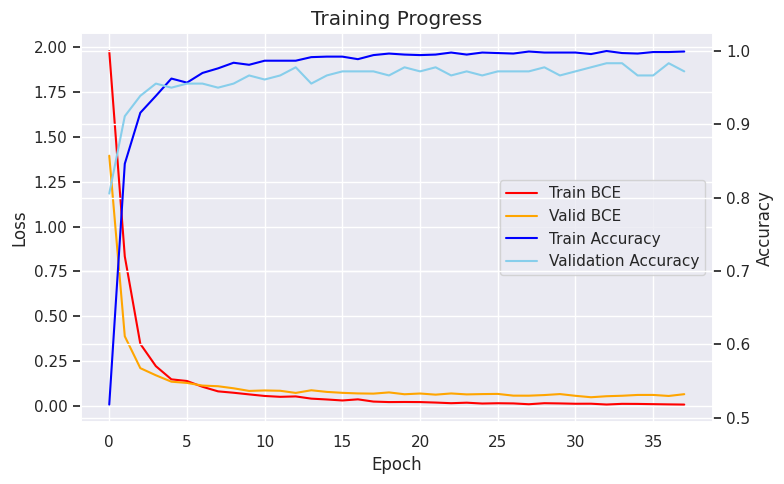

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax1 = plt.subplots(figsize=(8, 5))

# 첫 번째 y축: Loss
color1 = "tab:red"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
sns.lineplot(data=train_losses, label="Train BCE", ax=ax1, color="red")
sns.lineplot(data=valid_losses, label="Valid BCE", ax=ax1, color="orange")
ax1.tick_params(axis='y')

# 두 번째 y축: Accuracy
ax2 = ax1.twinx()
color2 = "tab:blue"
ax2.set_ylabel("Accuracy")
sns.lineplot(data=train_accs, label="Train Accuracy", ax=ax2, color="blue")
sns.lineplot(data=valid_accs, label="Validation Accuracy", ax=ax2, color="skyblue")
ax2.tick_params(axis='y')

# 범례 통합
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")
if ax2.legend_:
    ax2.legend_.remove()

plt.title("Training Progress", size="large")
plt.tight_layout()
plt.show()

### 📝 참고: 학습이 길어지면...?

현재 제작한 코드는 loss를 중간중간 계산하긴 하지만, 전체 학습과정에서 산출된 loss를 보관하고 있는 `train_losses` 와 같은 변수들은 오류가 발생하면 저장되지 않습니다. 그리고 시각화를 중간중간 가능하게 하는 코드가 있기는 하지만 많이 번거롭습니다. 이런 경우를 방지하기 위해 `wandb`라는 라이브러리들이 존재합니다. 이는 서버에 중간중간 기록을 보내 플롯을 그려주는 라이브러리입니다. 한 번 살펴보시고 도입해보세요 :)
- [Weight and Biases Colaboratory Tutorial](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb?_gl=1*1cyn3uu*_ga*MTQ5NjIyMTUxNy4xNzQ4Mzk2MDgw*_ga_JH1SJHJQXJ*czE3NTUyNjYzNzYkbzEwMiRnMSR0MTc1NTI2NjM5OCRqNjAkbDAkaDA.*_ga_GMYDGNGKDT*czE3NTUyNjYzODUkbzUkZzAkdDE3NTUyNjYzOTgkajYwJGwwJGgw)

### 📝 참고: `sklearn.classification`에 있는 모듈로도 계산이 될까요?

우리가 지금 파리 잡는데 도끼를 든 격이 아닌가 생각해볼 필요가 있습니다. 8*8 사이즈의 이미지 정도면 사실 머신러닝 모델로도 어느 정도 성능을 달성할 수 있습니다. 한 번 시도해보세요 :)

# 마치며
최종 검증데이터 결과와 테스트데이터 결과가 크게 차이나지 않고 성능이 좋으면 학습이 잘 마무리된 것입니다. 하지만 둘 사이의 갭이 너무 크거나 학습 중간에 train_loss는 줄고 있는데 valid_loss는 다시 증가하면 오버피팅이 일어나고 있는 것입니다. 주의해서 잘 학습시켜주세요 :)